# <center><u> Queueing Theory and Simulation Jupyter Notebook </u></center>
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
from math import factorial

import random
from random import randint

## Section 2 - Construction and simulation of queueing systems

### 2.1 Queueing systems in discrete time

***

$ a_k $ - number of jobs that arrive in period k

$ c_k $ - capacity during period k, i.e. number of jobs that can be served

$ d_k $ - number of departures in period k

$ L_k $ - number of jobs in the system at the end of period k, i.e. system length

Then we have the following basic queueing recursions:

$$ d_k = min\{L_{k-1}, c_k\} $$

$$ L_k = L_{k-1} + a_k - d_k $$

We can modify the recursion so that jobs can be served in the period they arrive with $ d_k = min\{L_{k-1} + a_k, c_k\} $

<font color='green'>Waiting time W and sojourn time J in discrete time? Notation the same for continuous version?</font>

<font color='green'>Define service rate as a function of queue length, specify tolerance threshold (See 2.1.6) </font>

***

Defining functions for simple queueing recursions:

In [2]:
def data_valid(vector, periods):
    # Convert input data for arrivals and capacity to numpy array
    
    if isinstance(vector, np.ndarray):
        return(vector)
    
    elif isinstance(vector, list):
        convert = np.array(vector, dtype=float)
        return(convert)
    
    elif isinstance(vector, int):
    # Deterministic input for single value repeated for all periods
        convert = vector*np.ones(periods, dtype=float)
        return(convert)
    
    elif isinstance(vector, float):
        convert = vector*np.ones(periods)
        return(convert)

def discreteQ(num, a, c, L0, serve_now=False, K=np.inf, rej='end'):
    # serve_now=False assumes jobs that arrive in period k cannot be served in period k
    # K infinity assumes no blocking
    
    a = data_valid(a, num)
    c = data_valid(c, num)
    
    d = np.zeros_like(a, dtype=float)
    L = np.zeros_like(a, dtype=float)
    L[0] = L0
    
    loss = np.zeros_like(a)
    
    if serve_now == False:
        # Jobs that arrive in period k can be served in period k+1
        
        for k in range(1,num):
            d[k] = min(c[k], L[k-1])
            
        # Standard queueing system assumes no blocking threshold K unless stated otherwise
            if K == np.inf:
                L[k] = L[k-1] + a[k] - d[k]
            else:
                if rej == 'start':
                    loss[k] = max(L[k-1] + a[k] - K, 0)
                    L[k] = L[k-1] + a[k] - d[k] - loss[k]
                elif rej == 'end':
                    loss[k] = max(L[k-1] + a[k] - d[k] - K, 0)
                    L[k] = L[k-1] + a[k] - d[k] - loss[k]
            
    elif serve_now == True:
        # Jobs that arrive in period k can be served in period k
        
        for k in range(1,num):
            d[k] = min(c[k], L[k-1] + a[k])
            
            if K == np.inf:
                L[k] = L[k-1] + a[k] - d[k] 
            else:
                if rej == 'start':
                    loss[k] = max(L[k-1] + a[k] - K, 0)
                    L[k] = L[k-1] + a[k] - d[k] - loss[k]
                elif rej == 'end':
                    loss[k] = max(L[k-1] + a[k] - d[k] - K, 0)
                    L[k] = L[k-1] + a[k] - d[k] - loss[k]
        
    return(L, a, d, c, loss)

def output_data(discreteQsim, var):
    if var == 'L':
        data = discreteQsim[0]
    elif var == 'a':
        data = discreteQsim[1]
    elif var == 'd':
        data = discreteQsim[2]
    elif var == 'c':
        data = discreteQsim[3]
    elif var == 'loss':
        data = discreteQsim[4]
        
    return(data)

***

**Exercise 2.1.1** - Discrete queue basic recursions

In [3]:
num = 4
a = [0,5,4,9]
c = 7
L0 = 8

sim = discreteQ(num,a,c,L0)
L = output_data(sim, 'L')
d = output_data(sim, 'd')

L, d

(array([8., 6., 4., 9.]), array([0., 7., 6., 4.]))

***
**Exercise 2.1.4** - Blocking

In [8]:
num = 4
a = [0,10,3,6]
c = [0,5,5,5]
K=8

sim = discreteQ(num,a,c,L0=0,K=8)
L = output_data(sim, 'L')
d = output_data(sim, 'd')
l = output_data(sim, 'loss')

L, d, l

(array([0., 8., 6., 7.]), array([0., 0., 5., 5.]), array([0., 2., 0., 0.]))

In [9]:
frac_lost = sum(l)/sum(a)
frac_lost

0.10526315789473684

***

**Exercise 2.1.6** - Cost Models

In [10]:
# Define queueing system
num = 5

a = [0,4,8,2,1]
c = [3,3,3,3,3]

L = [0]*len(a)
L[0] = 6
d = [0]*len(a)

p_cost = np.zeros(num)
h_cost = np.zeros(num)

p = 2 # service capacity cost parameter
h = 1 # holding cost

In [11]:
for i in range(1,len(a)):
    d[i] = min(L[i-1]+a[i], c[i])
    L[i] = L[i-1] + a[i] - d[i]
    p_cost[i] = p*c[i]
    h_cost[i] = h*L[i]
    
tot_cost = sum(p_cost) + sum(h_cost)
tot_cost, h_cost, p_cost

(63.0, array([ 0.,  7., 12., 11.,  9.]), array([0., 6., 6., 6., 6.]))

***
**Exercise 2.1.7** - Threshold control policy

* Server works at rate $c$ if number of jobs exceed $N$, otherwise is not used
* Policy ensures that server capacity is fully used or not at all

In [19]:
# Define queueing system
np.random.seed(10)
num = 20

N = 20 # server works if there are N jobs, otherwise is not used

a = 10*np.ones(num)
c = 12*np.ones(num)

L = np.zeros_like(a)
d = np.zeros_like(a)

L[0] = 0

for i in range(1,len(a)):
    if (L[i-1] < N):
        L[i] = L[i-1] + a[i] # d[i] remains zero
    else:
        d[i] = min(L[i-1], c[i])
        L[i] = L[i-1] + a[i] - d[i]

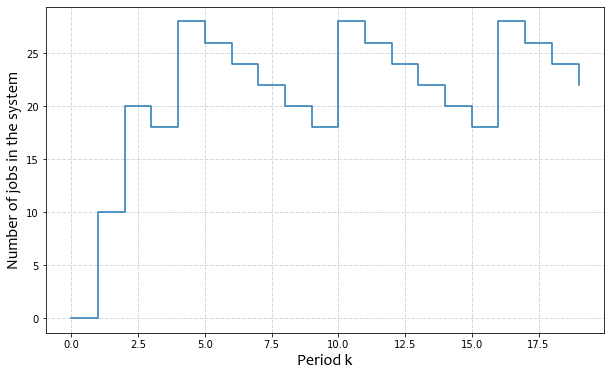

In [20]:
fig, ax = plt.subplots(figsize = (10,6))
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(lw=0.5, ls='-.', zorder = 1)
ax.set_xlabel('Period k', fontsize = 16, fontfamily='Candara')
ax.set_ylabel('Number of jobs in the system', fontsize = 16, fontfamily='Candara')
plt.plot(L, ds='steps-post')

***
**Exercise 2.1.8** - N-Policy cost model

* Machine switches on when system length hits $N$
* Machine switches off when system becomes empty (typically rarely hits exactly zero, so min threshold $M$ may be better)
* Cost $K$ to switch on machine
* Cost $\beta$ per period when machine is on
* Cost $h$ per job per period in the system

In [16]:
np.random.seed(5)
num = 100
a = np.random.randint(0,12,num)
c = np.random.randint(0,16,num)
L = np.zeros(num)
d = np.zeros(num)

L[0] = 10
N = 20

I = np.zeros(num)

for k in range(1,len(a)):
    # Turn off when system is empty
    if (L[k-1] == 0):
        d[k] = 0
        I[k] = 0
    # Turn on when system reaches threshold N
    elif (L[k-1] >= N):
        d[k] = min(L[k-1], c[k])
        I[k] = 1
    # Remain on/off until threshold is met
    elif (L[k-1] < N):
        if (I[k-1] == 0):
            d[k] = 0
            I[k] = 0
        else:
            d[k] = min(L[k-1], c[k])
            I[k] = 1
        
    L[k] = L[k-1] + a[k] - d[k]

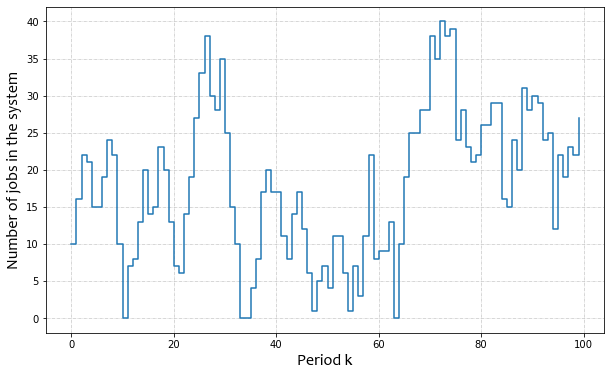

In [17]:
fig, ax = plt.subplots(figsize = (10,6))
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(lw=0.5, ls='-.', zorder = 1)
ax.set_xlabel('Period k', fontsize = 16, fontfamily='Candara')
ax.set_ylabel('Number of jobs in the system', fontsize = 16, fontfamily='Candara')
plt.plot(L, ds='steps-post')

Implementing associated costs:

In [18]:
beta = 1
h = 2
K = 10

on = 0 # number of times the machine is switched on

for j in range(1,len(I)):
    if I[j] > I[j-1]:
        on += 1
    else:
        pass
    
tot_cost = beta*sum(I) + h*sum(L) + K*on
tot_cost, on

(3711.0, 4)